In [1]:
from aif360.sklearn.datasets import fetch_compas
X,y = fetch_compas()
X

sex  age          age_cat              race  \
sex    race                                                               
Male   Other               Male   69  Greater than 45             Other   
       African-American    Male   34          25 - 45  African-American   
       African-American    Male   24     Less than 25  African-American   
       Other               Male   44          25 - 45             Other   
       Caucasian           Male   41          25 - 45         Caucasian   
...                         ...  ...              ...               ...   
       African-American    Male   23     Less than 25  African-American   
       African-American    Male   23     Less than 25  African-American   
       Other               Male   57  Greater than 45             Other   
Female African-American  Female   33          25 - 45  African-American   
       Hispanic          Female   23     Less than 25          Hispanic   

                         juv_fel_count  juv_misd_count  juv_other_count  \
sex    race                                                               
Male   Other                         0               0                0   
       African-American              0               0                0   
       African-American              0               0                1   
       Other                         0               0                0   
       Caucasian                     0               0                0   
...                                ...             ...              ...   
       African-American              0               0                0   
       African-American              0               0                0   
       Other                         0               0                0   
Female African-American              0               0                0   
       Hispanic                      0               0                0   

                         priors_count c_charge_degree  \
sex    race                                             
Male   Other                        0               F   
       African-American             0               F   
       African-American             4               F   
       Other                        0               M   
       Caucasian                   14               F   
...                               ...             ...   
       African-American             0               F   
       African-American             0               F   
       Other                        0               F   
Female African-American             3               M   
       Hispanic                     2               F   

                                          c_charge_desc  
sex    race                                              
Male   Other               Aggravated Assault w/Firearm  
       African-American  Felony Battery w/Prior Convict  
       African-American           Possession of Cocaine  
       Other                                    Battery  
       Caucasian              Possession Burglary Tools  
...                                                 ...  
       African-American                Deliver Cannabis  
       African-American   Leaving the Scene of Accident  
       Other              Aggravated Battery / Pregnant  
Female African-American   Battery on Law Enforc Officer  
       Hispanic                  Possession of Ethylone  

[6167 rows x 10 columns]

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, KBinsDiscretizer

def calculate_num_bins(num_unique_values, value_range):
    num_bins = min(6, int(np.log2(num_unique_values)) + 1)
    num_bins = min(num_bins, value_range)
    return num_bins


def preprocess_dataset(df, continuous_features=[], one_hot_encode=True, datasetName="Adult"):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder()

    numeric_columns = []
    categorical_columns = []

    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype == 'category' and col not in continuous_features:
            categorical_columns.append(col)
            if len(df[col].unique()) == 2:
                df[col] = label_encoder.fit_transform(df[col])
            elif one_hot_encode or (one_hot_encode and datasetName == "Adult" and col == 'race'):
                encoded_values = onehot_encoder.fit_transform(df[[col]])
                categories = onehot_encoder.categories_[0]
                new_cols = [col + '_' + str(category) for category in categories]
                encoded_df = pd.DataFrame(encoded_values.toarray(), columns=new_cols)
                df = pd.concat([df, encoded_df], axis=1)
                df.drop(col, axis=1, inplace=True)
        elif df[col].dtype == 'object' or df[col].dtype == 'category' and df[col].str.isnumeric().all() and col not in continuous_features:
            df[col] = df[col].astype(int)
            categorical_columns.append(col)
        elif col in continuous_features:
            numeric_columns.append(col)
            num_unique_values = len(df[col].unique())
            value_range = df[col].max() - df[col].min()
            num_bins = calculate_num_bins(num_unique_values, value_range)

            bin_discretizer = KBinsDiscretizer(n_bins=num_bins, encode='ordinal', strategy='uniform', subsample=None)
            bins = bin_discretizer.fit_transform(df[[col]])
            df[col] = bins.astype(int)
        else:
            if len(df[col].unique()) > 2:
                numeric_columns.append(col)
    return df, numeric_columns, categorical_columns

In [3]:
def load_compas():
    global X, y

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    TARGET_COLUMNS = 'two_year_recid'
    data = X
    data = data.drop(['c_charge_desc', 'age_cat'], axis=1)
    data, numeric_columns, categorical_columns = preprocess_dataset(data, continuous_features=[])

    data_df_copy = data.copy()

    y = pd.DataFrame(y, columns=[TARGET_COLUMNS])
    y,_,_ = preprocess_dataset(y, continuous_features=[])

    data[TARGET_COLUMNS] = y

    FEATURE_COLUMNS = data.columns[:-1]

    return data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns
data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns = load_compas()
data

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,two_year_recid
0,1,69,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,1,34,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,1,24,0,0,1,4,0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,1,44,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,1
4,1,41,0,0,0,14,0,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6162,1,23,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1
6163,1,23,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1
6164,1,57,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1
6165,0,33,0,0,0,3,1,1.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
data = load_compas()
data

(      sex  age  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
 0       1   69              0               0                0             0   
 1       1   34              0               0                0             0   
 2       1   24              0               0                1             4   
 3       1   44              0               0                0             0   
 4       1   41              0               0                0            14   
 ...   ...  ...            ...             ...              ...           ...   
 6162    1   23              0               0                0             0   
 6163    1   23              0               0                0             0   
 6164    1   57              0               0                0             0   
 6165    0   33              0               0                0             3   
 6166    0   23              0               0                0             2   
 
       c_charge_degree  ra

In [5]:
data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns = load_compas()

print(data.columns)

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_degree', 'race_African-American',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American',
       'race_Other', 'two_year_recid'],
      dtype='object')


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def calculate_metrics_and_split_data(data, features, target, classifier_type='logistic_regression',
                                     metrics=['accuracy'], attribute=None):
    """
    Train a classifier, predict on test data, calculate specified metrics from the confusion matrix,
    and optionally split the test data based on an attribute.

    :param data: DataFrame containing the dataset
    :param features: List of feature column names
    :param target: Name of the target column
    :param classifier_type: Type of classifier ('logistic_regression', 'svm', 'random_forest', 'naive_bayes')
    :param metrics: List of metrics to calculate ('accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn')
    :param attribute: Optional attribute to split the test data on, which should be binary (0 or 1)
    :return: Dictionary of requested metrics and optionally two DataFrames, one for each value of the attribute,
             and the trained model instance
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[FEATURE_COLUMNS], data[TARGET_COLUMNS], test_size=0.2, random_state=42)

    # Debugging: Print the shape of the train and test sets
    print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Initialize classifier
    classifiers = {
        'logistic_regression': LogisticRegression(max_iter=500, solver='saga'),
        'svm': SVC(),
        'random_forest': RandomForestClassifier(),
        'naive_bayes': GaussianNB()
    }
    classifier = classifiers[classifier_type]

    # Fit the classifier and predict
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1]  # True Positives
    tn = cm[0, 0]  # True Negatives
    fp = cm[0, 1]  # False Positives
    fn = cm[1, 0]  # False Negatives

    # Debugging: Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Calculate metrics
    metrics_dict = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='binary'),
        'recall': recall_score(y_test, y_pred, average='binary'),
        'f1': f1_score(y_test, y_pred, average='binary'),
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

    # Print accuracy
    print(f"Accuracy: {metrics_dict['accuracy']}")

    # Validate metrics
    results = {}
    for metric in metrics:
        if metric not in metrics_dict:
            raise ValueError(
                f"Unsupported metric '{metric}'. Choose from 'accuracy', 'precision', 'recall', 'f1', 'tp', 'tn', 'fp', 'fn'.")
        results[metric] = metrics_dict[metric]

#     if attribute is not None:
#         if attribute != target:
#             raise ValueError(f"The attribute for splitting should be the same as the target.")

        # Add target to test features
        X_test_df = X_test.copy()
        X_test_df[target] = y_test.values

#         # Split the test data into two groups
#         group_0 = X_test_df[X_test_df[attribute] == 0]
#         group_1 = X_test_df[X_test_df[attribute] == 1]

#         return results, group_0, group_1, classifier

    # Add the target column back to the test set for completeness
    X_test_df = X_test.copy()
    X_test_df[target] = y_test.values
    X_test_df['pred'] = y_pred

    # Debugging: Print the test data with all columns
    print("Test data with all columns:")
    print(X_test_df.head())

    return results, X_test_df, classifier

In [7]:
def generate_tn_fn_dataframes(test_df, target, attribute):
    group_0 = test_df[test_df[attribute] == 0]
    group_1 = test_df[test_df[attribute] == 1]
    print(f"Group 0 size: {group_0.shape[0]}")
    print(f"Group 1 size: {group_1.shape[0]}")
    y_true_0 = group_0[target]
    y_pred_0 = group_0['pred']
    tn_0, fp_0, fn_0, tp_0 = confusion_matrix(y_true_0, y_pred_0).ravel()
    print(f"Confusion Matrix for Group 0: TN={tn_0}, FP={fp_0}, FN={fn_0}, TP={tp_0}")
    y_true_1 = group_1[target]
    y_pred_1 = group_1['pred']
    tn_1, fp_1, fn_1, tp_1 = confusion_matrix(y_true_1, y_pred_1).ravel()
    print(f"Confusion Matrix for Group 1: TN={tn_1}, FP={fp_1}, FN={fn_1}, TP={tp_1}")
#     tn_df_0 = group_0[(group_0[target] == 0) & (group_0['pred'] == 0)]
#     fn_df_0 = group_0[(group_0[target] == 1) & (group_0['pred'] == 0)]
#     tn_df_1 = group_1[(group_1[target] == 0) & (group_1['pred'] == 0)]
#     fn_df_1 = group_1[(group_1[target] == 1) & (group_1['pred'] == 0)]
    
    tp_df_0 = group_0[(group_0[target] == 1) & (group_0['pred'] == 1)].drop(columns=[target, 'pred'])
    fp_df_0 = group_0[(group_0[target] == 0) & (group_0['pred'] == 1)].drop(columns=[target, 'pred'])
    tp_df_1 = group_1[(group_1[target] == 1) & (group_1['pred'] == 1)].drop(columns=[target, 'pred'])
    fp_df_1 = group_1[(group_1[target] == 0) & (group_1['pred'] == 1)].drop(columns=[target, 'pred'])
    
#     print(f"TN Group 0 size: {tn_df_0.shape[0]}")
#     print(f"FN Group 0 size: {fn_df_0.shape[0]}")
#     print(f"TN Group 1 size: {tn_df_1.shape[0]}")
#     print(f"FN Group 1 size: {fn_df_1.shape[0]}")
    
    print(f"TP Group 0 size: {tp_df_0.shape[0]}")
    print(f"FP Group 0 size: {fp_df_0.shape[0]}")
    print(f"TP Group 1 size: {tp_df_1.shape[0]}")
    print(f"FP Group 1 size: {fp_df_1.shape[0]}")
    
    return tp_df_0, fp_df_0, tp_df_1, fp_df_1

In [8]:
data, features, target, numeric_columns, categorical_columns = load_compas()

target = 'two_year_recid'
attribute = 'race_African-American'
classifier_type = 'logistic_regression'

# Calculate metrics and get the test DataFrame with predictions
results, test_df, trained_model = calculate_metrics_and_split_data(data, features, target, classifier_type, attribute=attribute)

# Generate DataFrames for true negatives and false negatives
tp_df_0, fp_df_0, tp_df_1, fp_df_1 = generate_tn_fn_dataframes(test_df, target, attribute)
print("Results:")
for metric, value in results.items():
    print(f"{metric}: {value}")
print("True Positives Group 0 (first 5 rows):")
print(tp_df_0.head())
print("False Positives Group 0 (first 5 rows):")
print(fp_df_0.head())
print("True Positives Group 1 (first 5 rows):")
print(tp_df_1.head())
print("False Positives Group 1 (first 5 rows):")
print(fp_df_1.head())

Training data shape: X_train: (4933, 13), y_train: (4933,)
Testing data shape: X_test: (1234, 13), y_test: (1234,)
Confusion Matrix:
[[311 264]
 [135 524]]
Accuracy: 0.6766612641815235
Test data with all columns:
      sex  age  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
3027    1   23              0               0                0             3   
410     0   24              0               0                1             6   
2484    0   22              0               0                0             1   
5929    1   28              0               0                0            20   
2827    1   27              0               0                0             1   

      c_charge_degree  race_African-American  race_Asian  race_Caucasian  \
3027                0                    1.0         0.0             0.0   
410                 0                    0.0         0.0             1.0   
2484                0                    1.0         0.0             0.0   
59

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


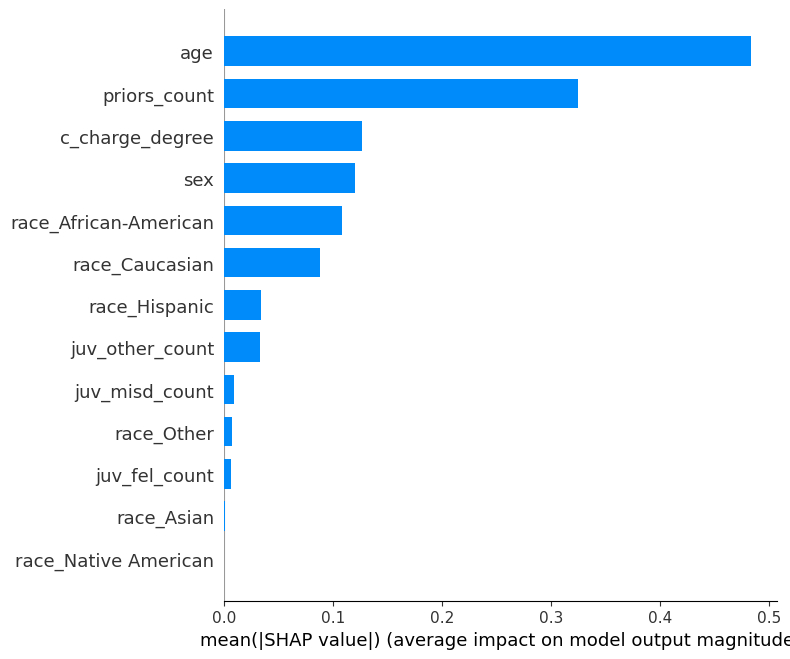

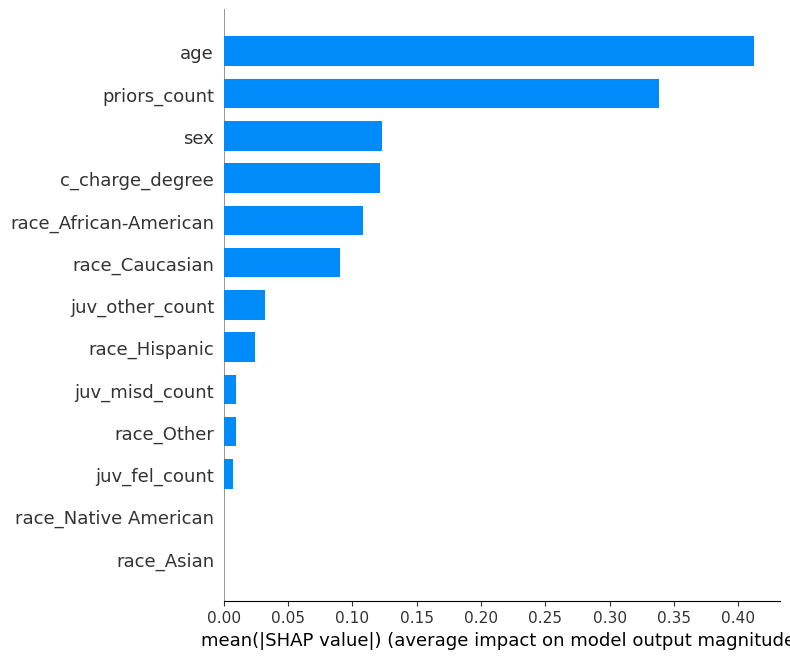

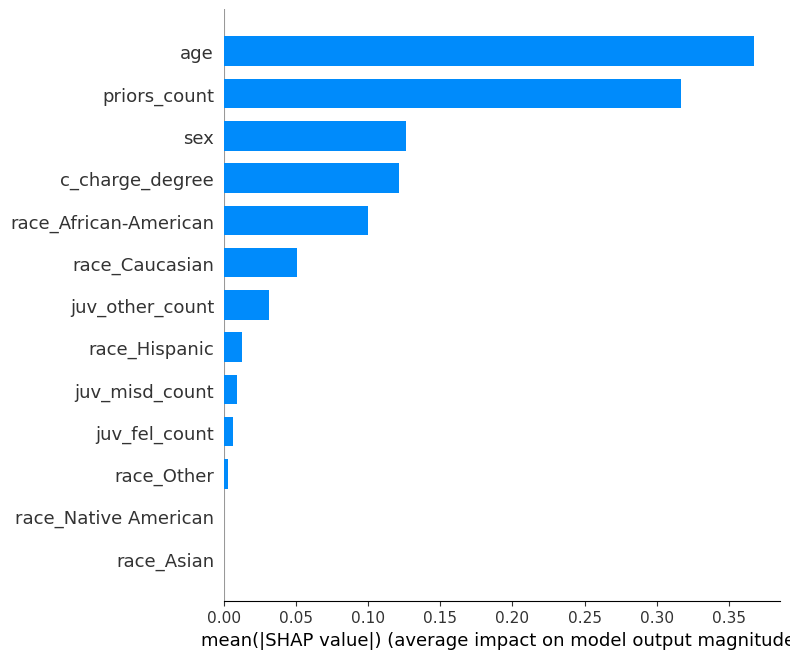

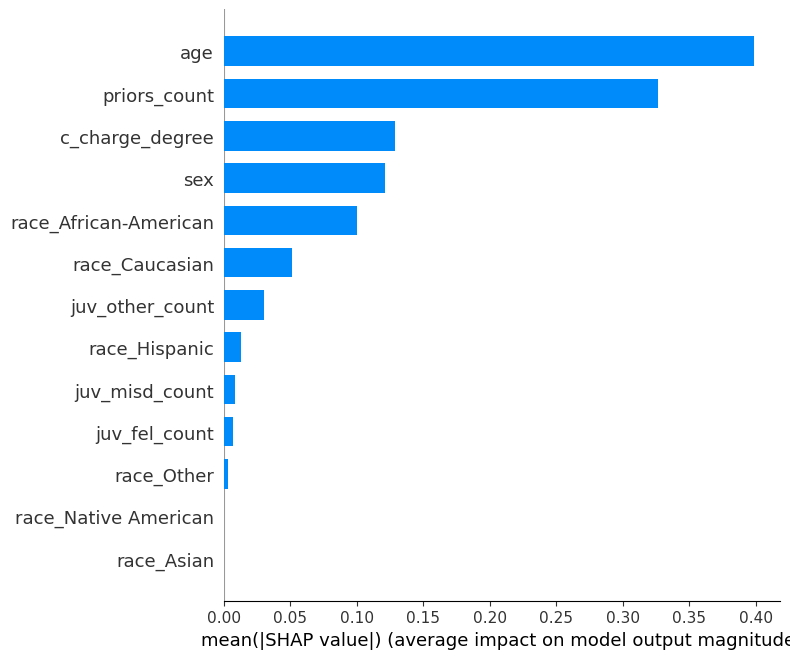

In [10]:
import shap

# Create an explainer using the trained model
explainer = shap.Explainer(trained_model, data[features])

# Compute SHAP values for each group
shap_values_tp_0 = explainer(tp_df_0)
shap_values_fp_0 = explainer(fp_df_0)
shap_values_tp_1 = explainer(tp_df_1)
shap_values_fp_1 = explainer(fp_df_1)

# Summarize the SHAP values
shap.summary_plot(shap_values_tp_0, tp_df_0, plot_type="bar")
shap.summary_plot(shap_values_fp_0, fp_df_0, plot_type="bar")
shap.summary_plot(shap_values_tp_1, tp_df_1, plot_type="bar")
shap.summary_plot(shap_values_fp_1, fp_df_1, plot_type="bar")

SHAP Beeswarm for True Positives Group 0:


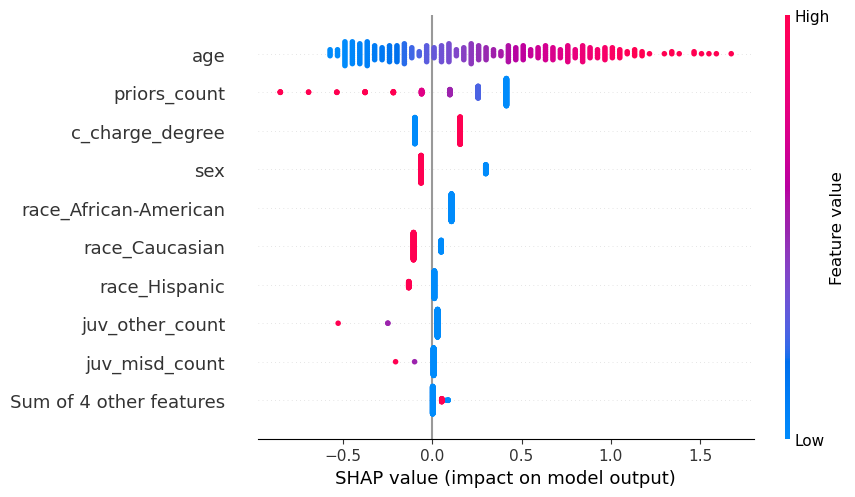

SHAP Beeswarm for False Positives Group 0:


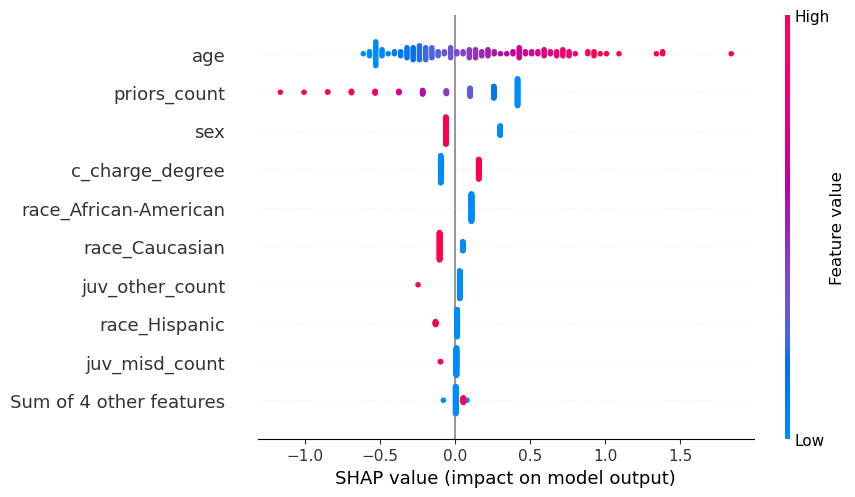

SHAP Beeswarm for True Positives Group 1:


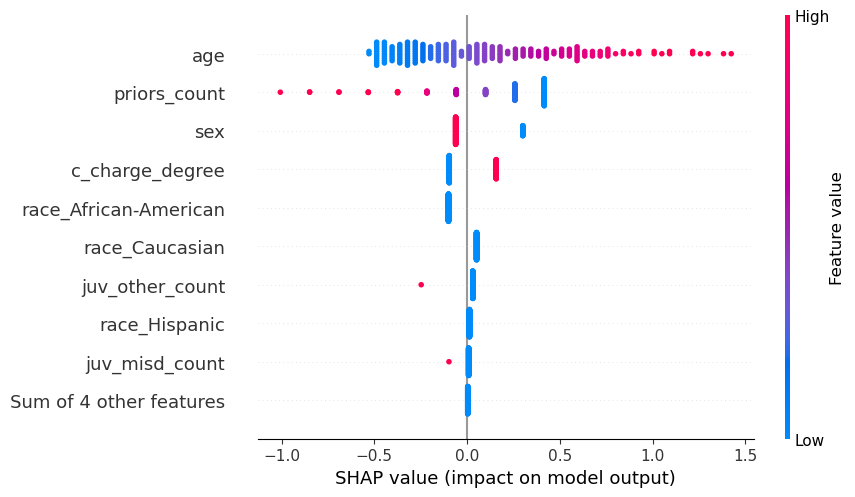

SHAP Beeswarm for False Positives Group 1:


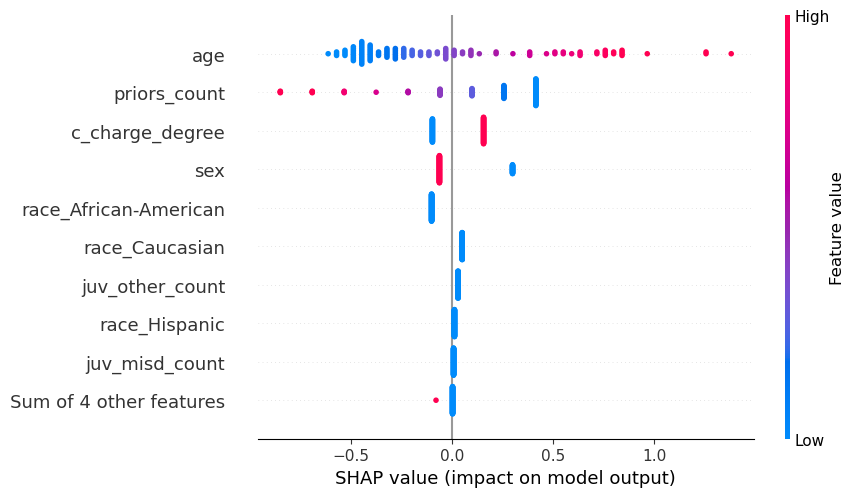

In [12]:
# Generate beeswarm plots
print("SHAP Beeswarm for True Positives Group 0:")
shap.plots.beeswarm(shap_values_tp_0)
print("SHAP Beeswarm for False Positives Group 0:")
shap.plots.beeswarm(shap_values_fp_0)
print("SHAP Beeswarm for True Positives Group 1:")
shap.plots.beeswarm(shap_values_tp_1)
print("SHAP Beeswarm for False Positives Group 1:")
shap.plots.beeswarm(shap_values_fp_1)

In [14]:
# Initialize JS visualization library for SHAP
shap.initjs()

# Generate force plots for the first instance in each group
print("SHAP Force Plot for the first instance in True Positives Group 0:")
shap.plots.force(shap_values_tp_0[0])
print("SHAP Force Plot for the first instance in False Positives Group 0:")
shap.plots.force(shap_values_fp_0[0])
print("SHAP Force Plot for the first instance in True Positives Group 1:")
shap.plots.force(shap_values_tp_1[0])
print("SHAP Force Plot for the first instance in False Positives Group 1:")
shap.plots.force(shap_values_fp_1[0])

SHAP Force Plot for the first instance in True Positives Group 0:
SHAP Force Plot for the first instance in False Positives Group 0:
SHAP Force Plot for the first instance in True Positives Group 1:
SHAP Force Plot for the first instance in False Positives Group 1:
